In [1]:
import torch
device = torch.device("cuda")
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix

from torchvision.models import resnet50, ResNet50_Weights

# Using pretrained weights:
weights = ResNet50_Weights.IMAGENET1K_V2
model = resnet50(weights=weights).to(device)
model.fc = torch.nn.Identity()

model.eval()

print("Loaded updated model")

Loaded updated model


In [2]:
import os
import pandas as pd
from PIL import Image
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision.io import read_image
from torchvision import transforms as T


class CountingDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path) / 255.0
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        return image, label
    
annotations_file = "../Apple/counting/train/train_ground_truth.txt"
img_dir = "../Apple/counting/train/images/"

transform = T.Compose([
    T.Resize((224,224), antialias=True),
    T.RandomHorizontalFlip(p=0.5),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train_dataset = CountingDataset(annotations_file, img_dir, transform=transform)

batch_size = 32
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

In [3]:
from tqdm import tqdm

features = torch.zeros(size=(0, 2048))
labels = torch.zeros((0))

with torch.no_grad():
    for batch_input, batch_target in tqdm(train_dataloader):
            pred = model(batch_input.to(device))
            features = torch.cat([features, pred.cpu()])
            labels = torch.cat([labels, batch_target.cpu()])

100%|██████████| 2019/2019 [03:17<00:00, 10.21it/s]


In [582]:
layers = torch.nn.Sequential(
    torch.nn.Linear(2048, 512, bias=False),
    torch.nn.BatchNorm1d(512),
    torch.nn.Dropout(p=0.5),
    torch.nn.ReLU(),
    torch.nn.Linear(512, 7),
).to(device)

torch.nn.init.trunc_normal_(layers[0].weight, std=0.02)
torch.nn.init.constant_(layers[-1].weight, 0)
torch.nn.init.constant_(layers[-1].bias, 0)


optimizer = torch.optim.SGD(params=layers.parameters(), lr=1e-1, momentum=0.99)

criterion = torch.nn.CrossEntropyLoss()

errors = []

In [583]:
for i in range(100):
    optimizer.zero_grad()

    pred = layers(features.to(device))
    loss = criterion(pred, labels.to(device).long())

    loss.backward()
    optimizer.step()

    error = (labels != pred.argmax(dim=1).cpu()).sum() / len(labels)
    errors.append(error.item())

pred = layers(features.to(device))

In [584]:
torch.save(layers.state_dict(), "layers.pt")

In [585]:
errors[-1]

0.19434940814971924

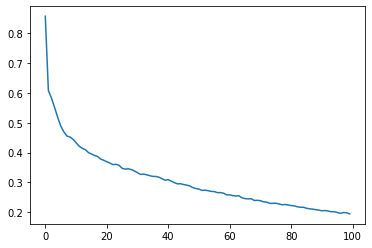

In [586]:
plt.plot(errors)

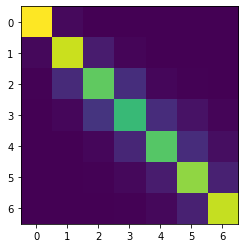

In [587]:
cm = confusion_matrix(labels.cpu().numpy(), pred.argmax(dim=1).cpu().numpy())
plt.imshow(cm)